In [57]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from collections import Counter
from string import punctuation

from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import skimage

import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from keras.preprocessing.image import (load_img
                                       , array_to_img
                                       , img_to_array
                                       , ImageDataGenerator)
import keras

In [2]:
file = open('photo.json', 'r')

In [3]:
stop = 200000
all_data = []

for i, line in enumerate(file):
    if i%200000 == 0:
        print(i)
    if i == stop:
        break
    
    data = json.loads(line)
    
    photo_id = data['photo_id']
    business_id = data['business_id']
    caption = data['caption']
    label = data['label']
    
    all_data.append([photo_id
                     , business_id
                     , caption
                     , label])
    
df = pd.DataFrame(all_data, columns = ['photo_id'
                                       , 'business_id'
                                       , 'caption'
                                       , 'label'])

file.close()

0


In [4]:
df.head()

,photo_id,business_id,caption,label
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside
1,YjxBE88Bf6CmTEF2LP1UNA,Kn23LDd740SBVJ7mum0fwg,,inside
2,1f7izSjM0WjkDRIVbPy1yw,ZkGDCVKSdf8m76cnnalL-A,,food
3,NcSlcDTEEeOaixotOPk-rA,bF8gv7k_rwZtiDLP2ZB04w,,inside
4,5IiIo5UKEW0lWqZ6sWrY_A,50Anorn0DJXFhBr9a9_gHQ,,inside


In [5]:
df.label.value_counts()

food       114874
inside      52448
drink       18121
outside     11534
menu         3023
Name: label, dtype: int64

In [6]:
df['photo_path'] = '/home/david/Downloads/photos/'+ df.photo_id + '.jpg'

In [7]:
df.head(1)

,photo_id,business_id,caption,label,photo_path
0,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,,inside,/home/david/Downloads/photos/MllA1nNpcp1kDteVg...


In [8]:
classes_ctn = pd.DataFrame(df.label.value_counts())
classes_ctn

,label
food,114874
inside,52448
drink,18121
outside,11534
menu,3023


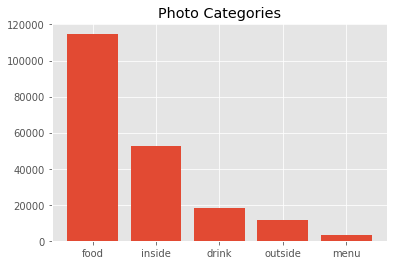

In [9]:
plt.bar(classes_ctn.index, classes_ctn.label)
plt.title('Photo Categories')
plt.savefig('photo_cat_ctn.png');

In [10]:
df_short_balanced = df.groupby('label').apply(lambda x: x.sample(n=3023)).reset_index(drop=True)

In [11]:
df_short_balanced.label.value_counts()

drink      3023
inside     3023
food       3023
menu       3023
outside    3023
Name: label, dtype: int64

In [12]:
df_short_balanced.shape

(15115, 5)

In [13]:
img = cv2.imread('/home/david/Downloads/photos/'+ df.photo_id.iloc[0] + '.jpg'
                 , 0) #1 is color, 0, is grayscale, -1 is alpha channel


In [14]:
print(img)

[[  0  43   8 ...  11  32   0]
 [ 34 150 158 ... 142 115  19]
 [  8 176 200 ... 171 172  29]
 ...
 [ 11  15  15 ...  18  17   4]
 [ 17  17  22 ...  10  13   4]
 [  3   9  14 ...   4  10   2]]


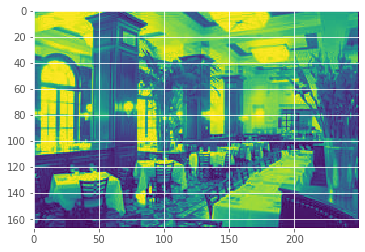

In [15]:
plt.imshow(img);

Reference: https://github.com/netik1020/Concise-iPython-Notebooks-for-Deep-learning/blob/master/Image_Classifier/skin_cancer_classification_1.ipynb

In [16]:
df_short_balanced.head(1)

,photo_id,business_id,caption,label,photo_path
0,wqC5Y6Ofqls-m7k323XP5A,ICdoTODBaprN0UReete9VQ,,drink,/home/david/Downloads/photos/wqC5Y6Ofqls-m7k32...


In [17]:
img1 = load_img(df_short_balanced.photo_path.iloc[0]
              , grayscale=True
              , target_size=(150,150))

img2 = load_img(df_short_balanced.photo_path.iloc[1]
              , grayscale=True
              , target_size=(150,150))

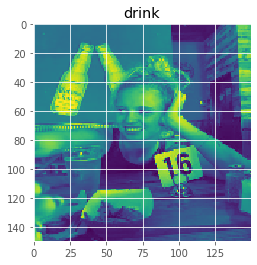

In [18]:
plt.imshow(img1)
plt.title(df_short_balanced.label.iloc[0]);

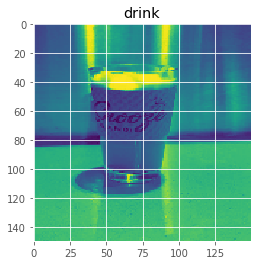

In [19]:
plt.imshow(img2)
plt.title(df_short_balanced.label.iloc[1]);

In [20]:
X = [load_img(df_short_balanced.photo_path.iloc[x]
                      , grayscale=True
                      , target_size=(128,128)) for x in range(len(df_short_balanced))]

In [21]:
len(X)

15115

In [22]:
test_img = img_to_array(X[0]).flatten()

In [23]:
type(test_img)

numpy.ndarray

In [24]:
photo_arr = []
for i in range(len(df_short_balanced)):
    photo_arr.append(img_to_array(X[i]).flatten())

In [25]:
len(photo_arr)

15115

In [26]:
len(photo_arr[0])

16384

In [27]:
pca = PCA(n_components=1000)

In [28]:
photo_pca = pca.fit(photo_arr)

In [29]:
photo_red = photo_arr @ photo_pca.components_[0:5].T

In [30]:
photo_pca.components_[0:1000].T[4]

array([ 9.33935447e-03,  1.20018841e-02, -6.23096345e-03,  7.88430989e-03,
        3.22550579e-04,  9.90593993e-03,  6.52383489e-03, -1.25107907e-02,
        5.63888631e-03, -6.38649886e-03,  9.62387897e-03, -9.18695806e-04,
        5.85567832e-03,  1.01398773e-02,  1.04953559e-02, -9.35131777e-03,
       -1.34492855e-03,  2.77436947e-03,  1.22384784e-02, -9.91361905e-03,
        5.49137631e-03, -8.57825863e-03,  1.00012243e-02, -9.34365427e-04,
        1.98168314e-03, -4.10557054e-03,  1.00767804e-02,  1.34131727e-02,
        1.30799054e-02, -2.02663960e-03,  2.87974603e-04,  3.67788604e-03,
       -8.59907831e-03, -1.75924782e-02, -7.07970705e-04, -4.17189798e-03,
        5.12978911e-04,  1.70742943e-03,  1.28529907e-02,  1.15721558e-02,
       -7.07828151e-03,  4.53872030e-03,  1.33948794e-02,  3.04727454e-03,
       -8.47519918e-03,  6.31271882e-03, -1.32676917e-02,  5.19410120e-03,
        2.19940399e-03,  2.95413143e-03,  1.32988546e-02, -1.04241272e-03,
        6.29956108e-03,  

In [31]:
photo_red[4]

array([13138.91651646, -5906.18741993,  -745.43696532, -3296.7373328 ,
         889.98139431])

In [32]:
photo_arr[0][:5]

array([99., 99., 98., 97., 97.], dtype=float32)

In [33]:
len(photo_red[0])

5

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(photo_arr
                                                   , df_short_balanced.label
                                                   , stratify=df_short_balanced.label
                                                   , random_state=42)

# SVM Classifier: Takes TOO Long!!!

In [35]:
# from sklearn import svm
# model = svm.SVC(kernel='linear'
#                , probability=True)
# model.fit(X_train, y_train)

In [36]:
# y_pred = model.predict(X_test)

In [37]:
# y_pred

In [38]:
# y_pred[0]

In [39]:
# y_test_val = y_test.values
# y_test_val

In [40]:
# y_test_val[0]

In [41]:
# print(len(y_pred))
# print(len(y_test))

In [42]:
# test = [y_pred[x]==y_test_val[x] for x in range(len(y_pred))]

In [43]:
#t = 0
# for x in test:
#     if x==True:
#         t+=1
# t        

In [44]:
# t/len(y_pred)

# Stochastic GD Model

In [45]:
sgd_clf = SGDClassifier(random_state=42
                        , max_iter=1000
                        , tol=1e-3)


In [46]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
y_pred = sgd_clf.predict(X_test)

In [48]:
y_pred

array(['outside', 'menu', 'menu', ..., 'menu', 'drink', 'menu'],
      dtype='<U7')

In [49]:
y_pred[0]

'outside'

In [50]:
y_test_val = y_test.values
y_test_val

array(['menu', 'inside', 'food', ..., 'food', 'drink', 'menu'],
      dtype=object)

In [51]:
print(len(y_pred))
print(len(y_test))

3779
3779


In [52]:
test = [y_pred[x]==y_test_val[x] for x in range(len(y_pred))]

In [53]:
t = 0
for x in test:
    if x==True:
        t+=1
t   

1124

In [54]:
t/len(y_pred)

0.29743318338184704

In [58]:
cross_val_score(sgd_clf, photo_arr, df_short_balanced.label, cv=10)

array([0.32079208, 0.32805281, 0.31749175, 0.32715232, 0.32913907,
       0.30264901, 0.33112583, 0.3       , 0.29271523, 0.28741722])

In [60]:
sgd_clf_cv_10 = np.array([0.32079208, 0.32805281, 0.31749175, 0.32715232, 0.32913907,
       0.30264901, 0.33112583, 0.3       , 0.29271523, 0.28741722])

In [61]:
sgd_clf_cv_10.mean()

0.313653532

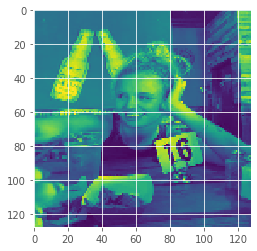

In [55]:
plt.imshow(X[0]);

In [56]:
X_hog = [hog(X[_]
            , pixels_per_cell=(12, 12)
            , cells_per_block=(2,2)
            , orientations=8
            , visualise=True
            , block_norm='L2-Hys')[1] for _ in range(len(df_short_balanced))

SyntaxError: unexpected EOF while parsing (<ipython-input-56-b54b014b766c>, line 6)

In [ ]:
img1_hog = hog(X[0]
            , pixels_per_cell=(12, 12)
            , cells_per_block=(2,2)
            , orientations=8
            , visualise=True
            , block_norm='L2-Hys')[0]

In [ ]:
img1_hog

In [ ]:
km = ImageDataGenerator(rescale=5/255)

data = km.flow_from_dataframe(df_short_balanced
                                   , x_col='photo_path'
                                   , y_col='label'
                                   , target_size=(100,100)
                                   , batch_size=10
                                   , class_mode='categorical'
                                   )

In [ ]:

fig, ax = plt.subplots(1,2)
fig.set_size_inches(8,6)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    for a in ax]
 
ax[0].imshow(X[123])
ax[0].set_title(y[123])
ax[1].imshow(img_test_hog)
ax[1].set_title(y[123] + ' hogged')
plt.show()

In [ ]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(pixels_per_cell=(8, 8)
                        , cells_per_block=(2,2)
                        , orientations=9
                        , block_norm='L2-Hys'
                        )

scalify = StandardScaler()
one_hot = OneHotEncoder()